In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Dense, Embedding, Flatten, Dropout,
                                     LSTM, Bidirectional)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, accuracy_score, f1_score


In [2]:
# Загрузка данных IMDB
vocab_size = 10000  # Ограничение на количество слов
max_len = 500  # Ограничение длины отзыва

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

# Разделение обучающих данных на обучающую и валидационную выборки
x_train, x_val = x_train[:20000], x_train[20000:]
y_train, y_val = y_train[:20000], y_train[20000:]

# Приведение всех отзывов к одинаковой длине
x_train = pad_sequences(x_train, maxlen=max_len)
x_val = pad_sequences(x_val, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)


In [3]:
# Функция векторизации из примера
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0  # Устанавливаем единицу по индексу
    return results

# Векторизация входных данных
x_train_vec = vectorize_sequences(x_train, dimension=10000)
x_val_vec = vectorize_sequences(x_val, dimension=10000)
x_test_vec = vectorize_sequences(x_test, dimension=10000)

# Размер входного вектора
input_dim = 10000

# Автокодировщик
input_ = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_)  # Сжатое представление
encoded = Dense(64, activation='relu')(encoded)  # Еще одно сжатие
decoded = Dense(input_dim, activation='sigmoid')(encoded)  # Восстановление данных

# Определение модели автокодировщика
autoencoder = Model(input_, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Обучение автокодировщика
autoencoder.fit(
    x_train_vec, x_train_vec,
    epochs=5, batch_size=64,
    validation_data=(x_val_vec, x_val_vec)
)

# Кодировщик: Извлекаем сжатое представление
encoder = Model(input_, encoded)

# Получаем сжатое представление данных
x_train_encoded = encoder.predict(x_train_vec)
x_val_encoded = encoder.predict(x_val_vec)
x_test_encoded = encoder.predict(x_test_vec)

print("Форма сжатого представления:", x_train_encoded.shape)  # (samples, 64)

Epoch 1/5
313/313 [==============================] - 31s 95ms/step - loss: 0.0806 - val_loss: 0.0447
Epoch 2/5
313/313 [==============================] - 27s 86ms/step - loss: 0.0436 - val_loss: 0.0437
Epoch 3/5
313/313 [==============================] - 27s 87ms/step - loss: 0.0429 - val_loss: 0.0433
Epoch 4/5
313/313 [==============================] - 27s 86ms/step - loss: 0.0425 - val_loss: 0.0430
Epoch 5/5
782/782 [==============================] - 2s 2ms/step
Форма сжатого представления: (20000, 64)


In [4]:
# Полносвязная модель
model_dense = Sequential([
    Dense(254, activation='relu', input_shape=(64,)),  # Вход: сжатое представление (размерность 64)
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Выходной слой для бинарной классификации
])

# Компиляция модели
model_dense.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
model_dense.summary()

# Обучение модели
history_dense = model_dense.fit(
    x_train_encoded, y_train,  # Используем сжатые данные
    epochs=30,
    batch_size=512,
    validation_data=(x_val_encoded, y_val)
)

test_loss, test_acc = model_dense.evaluate(x_test_encoded, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 254)               16510     
                                                                 
 dropout (Dropout)           (None, 254)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32640     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 49279 (192.50 KB)
Trainable params: 49279 (192.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
40/40 [==============================] - 1s 12ms/step - loss: 0.6259 - accuracy: 0.6966 - val_loss: 0.4529 - val_accuracy: 0.7900
Epoch 2/3

In [5]:
embedding_dim = 8

model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

# Обучение
history_lstm = model_lstm.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_val, y_val))

test_loss, test_acc = model_lstm.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 8)            80000     
                                                                 
 bidirectional (Bidirection  (None, 128)               37376     
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 117505 (459.00 KB)
Trainable params: 117505 (459.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
157/157 [==============================] - 119s 736ms/step - loss: 0.6


Dense Model Evaluation:
782/782 [==============================] - 1s 1ms/step
Accuracy: 0.8229
F1 Score (weighted): 0.8224

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83     12500
           1       0.86      0.77      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



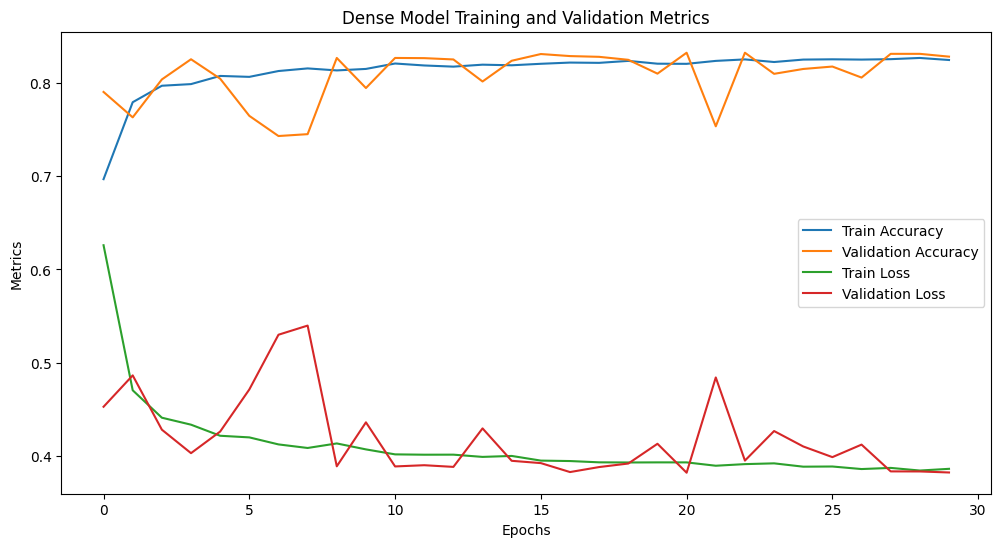


BiLSTM Model Evaluation:
782/782 [==============================] - 57s 73ms/step
Accuracy: 0.8657
F1 Score (weighted): 0.8656

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87     12500
           1       0.89      0.84      0.86     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



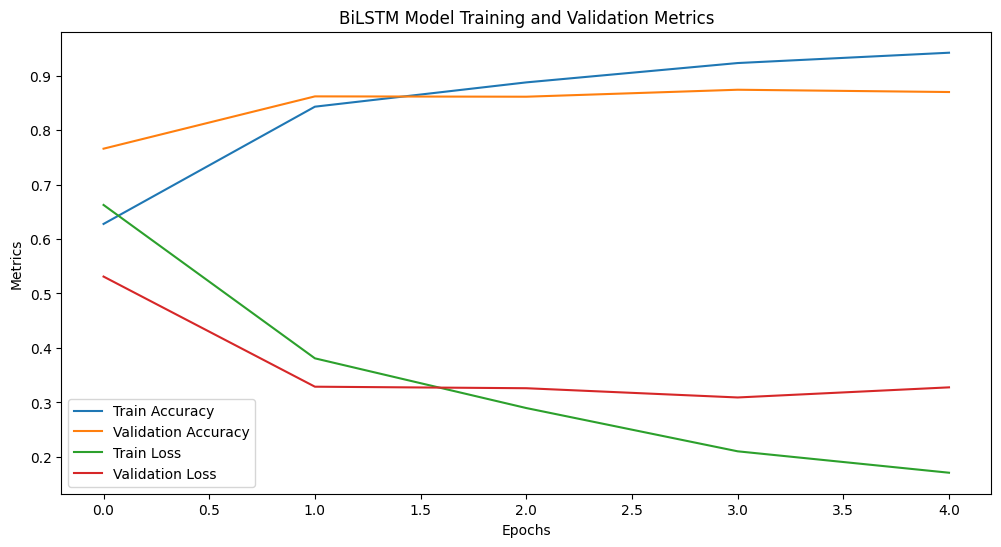

In [6]:
# Функция для оценки модели
def evaluate_model(model, history, name, x_test_input):
    print(f"\n{name} Evaluation:")

    # Предсказание и метрики
    y_pred = (model.predict(x_test_input) > 0.5).astype("int32")
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Графики метрик обучения
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()

evaluate_model(model_dense, history_dense, "Dense Model", x_test_encoded)

# Оценка BiLSTM модели на стандартных тестовых данных
evaluate_model(model_lstm, history_lstm, "BiLSTM Model", x_test)
